In [1]:
import tensorflow as tf

# Enable TensorFlow device placement logging
tf.debugging.set_log_device_placement(False)

# Check if GPU is available and set memory growth
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

Num GPUs Available:  1


In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import pandas as pd

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import hamming_loss

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, RMSprop
import pynvml
import time

from sklearn.preprocessing import StandardScaler


New Classification
- 0=everything else
- 1=walking
- 2=descending stairs
- 3=ascending stairs


# RRN

### Train Test Split

In [3]:
demograph = pd.read_csv('participant_demog.csv')
patient_ids = demograph['subj_id'].unique()
train_ids, test_ids = train_test_split(patient_ids, test_size=0.4, random_state=42)

# Split the data based on patient IDs
train_df =  demograph[demograph['subj_id'].isin(train_ids)]
test_df =  demograph[demograph['subj_id'].isin(test_ids)]

print("Train Patient IDs:", train_ids)
print("Test Patient IDs:", test_ids)

Train Patient IDs: ['id86237981' 'id34e056c8' 'id7c20ee7a' 'id5993bf4a' 'idd80ac2b4'
 'id5308a7d6' 'id82b9735c' 'id079c763c' 'ida61e8ddf' 'idbae5a811'
 'idecc9265e' 'idb221f542' 'id1f372081' 'id4ea159a8' 'id8e66893c'
 'idf5e3678b' 'id9603e9c3' 'id687ab496' 'idff99de96']
Test Patient IDs: ['idfc5f05e4' 'id37a54bbf' 'id00b70b13' 'idf1ce9a0f' 'idc91a49d0'
 'id1c7e64ad' 'idf540d82b' 'id1165e00c' 'idc735fc09' 'idabd0c53c'
 'id8af5374b' 'id3e3e50c7' 'id650857ca']


In [4]:
def load_features(id_df, featured=True):
    X = []
    y = []
    for index, row in id_df.iterrows():
        id = row['subj_id']
        print(f'processing patient {id}')
        if featured==True:
            output_dir = 'featured'
            pp = pd.read_csv(f'{output_dir}/{id}.csv') 
            X.append(pp.drop(columns=['activity']).values)
        else:
            output_dir = 'filtered'
            pp = pd.read_csv(f'{output_dir}/{id}.csv') 
            # norm_columns = [col for col in pp.columns if col.endswith('_norm')]
            norm_columns = 'lw_norm'
            X.append(pp[norm_columns].values)
            pp['activity'] = pp['activity'].apply(lambda x: x if x in [1, 2, 3] else 0)

        y.extend(pp['activity'].values)
    return np.vstack(X), np.array(y)

In [5]:
featured = True
X_train, y_train = load_features(train_df, featured=featured)
X_test, y_test = load_features(test_df, featured=featured)

processing patient id5993bf4a
processing patient idd80ac2b4
processing patient id82b9735c
processing patient idff99de96
processing patient id4ea159a8
processing patient id8e66893c
processing patient id34e056c8
processing patient id86237981
processing patient idf5e3678b
processing patient idecc9265e
processing patient id687ab496
processing patient id1f372081
processing patient id079c763c
processing patient idbae5a811
processing patient id7c20ee7a
processing patient id5308a7d6
processing patient ida61e8ddf
processing patient id9603e9c3
processing patient idb221f542
processing patient idabd0c53c
processing patient id8af5374b
processing patient id650857ca
processing patient idc91a49d0
processing patient id1c7e64ad
processing patient idc735fc09
processing patient id37a54bbf
processing patient id3e3e50c7
processing patient idf1ce9a0f
processing patient id00b70b13
processing patient id1165e00c
processing patient idfc5f05e4
processing patient idf540d82b


In [6]:
# Normalize train and test separately to avoid leaking
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

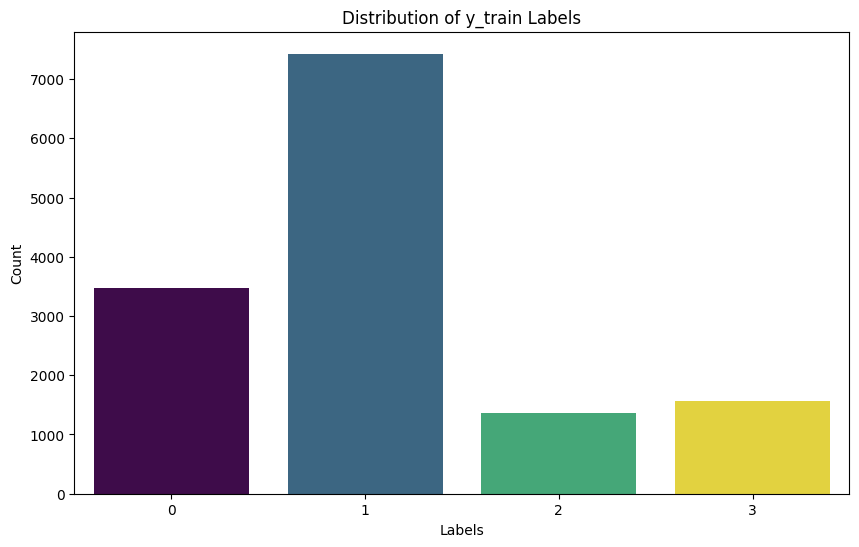

In [7]:
# Count the occurrences of each label
label_counts = pd.Series(y_train).value_counts().sort_index()

# Convert label_counts to DataFrame for plotting with hue
label_counts_df = label_counts.reset_index()
label_counts_df.columns = ['Labels', 'Count']

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Labels', y='Count', hue='Labels', data=label_counts_df, palette='viridis', dodge=False)
plt.title('Distribution of y_train Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.legend([],[], frameon=False)  # Remove the legend
plt.show()

In [8]:
from sklearn.utils.class_weight import compute_class_weight

# There is an imbalance in the dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}
print(class_weights_dict)

{0: 0.994535519125683, 1: 0.46547314578005117, 2: 2.5277777777777777, 3: 2.2195121951219514}


In [9]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [45]:
np.shape(X_train)

(13832, 16, 1)

## Train Model 1

In [37]:
# Start checking energy usage
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
start_energy = pynvml.nvmlDeviceGetPowerUsage(handle)

start_time = time.time()

# Define the RNN model
model = Sequential()
model.add(LSTM(25, input_shape=(X_train.shape[1], 1), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(10))
model.add(Dropout(0.5))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Output layer for classification

# Compile the model with sparse_categorical_crossentropy
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=2, class_weight=class_weights_dict)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 16, 25)            2700      
                                                                 
 dropout_12 (Dropout)        (None, 16, 25)            0         
                                                                 
 lstm_16 (LSTM)              (None, 10)                1440      
                                                                 
 dropout_13 (Dropout)        (None, 10)                0         
                                                                 
 dense_9 (Dense)             (None, 4)                 44        
                                                                 
Total params: 4,184
Trainable params: 4,184
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
433/433 - 6s - loss: 1.0197 - accuracy: 0

In [38]:
#Energy usage check
end_energy = pynvml.nvmlDeviceGetPowerUsage(handle)
energy_consumed = end_energy - start_energy
print(f"Energy Consumed: {energy_consumed} mW")
pynvml.nvmlShutdown()

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")

Energy Consumed: 277 mW
Execution Time: 128.42810797691345 seconds


## Evaluation Plot Model 1

In [39]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test
report = classification_report(y_true, y_pred_classes, zero_division=0, output_dict=True)
print(classification_report(y_true, y_pred_classes, zero_division=0))

296/296 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2379
           1       1.00      0.90      0.95      5083
           2       0.96      0.97      0.97       936
           3       0.69      1.00      0.82      1066

    accuracy                           0.95      9464
   macro avg       0.91      0.97      0.93      9464
weighted avg       0.96      0.95      0.95      9464



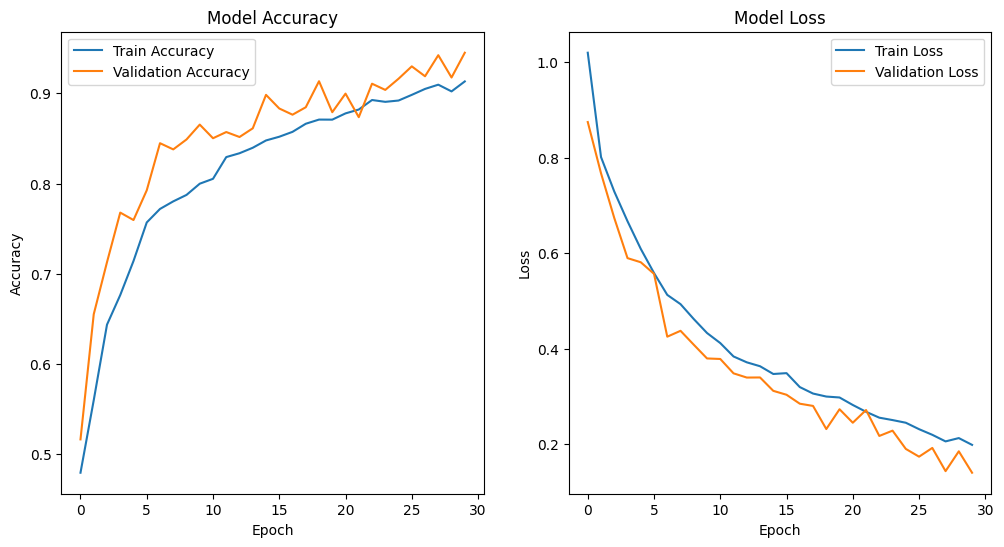

In [40]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

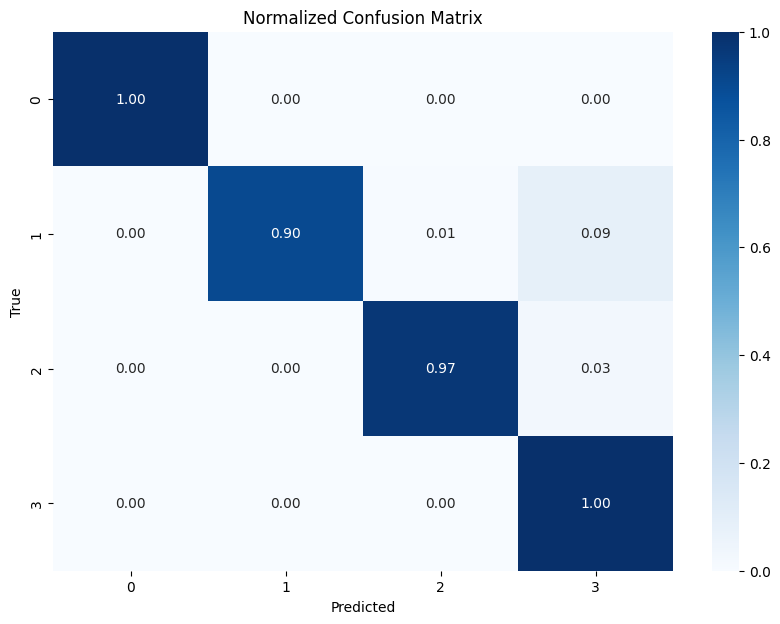

In [41]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()